In [2]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt

In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

# 1. reading in unspliced and spliced counts

In [3]:
adata_rna = scv.read('/home/ouyangkang/data/multivelo/velocyto/10X_multiome_mouse_brain.loom', cache=True)

In [4]:
adata_rna

AnnData object with n_obs × n_vars = 4881 × 32285
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
adata_rna.obs_names = adata_rna.obs_names.str.split(':').str[1].str[:-1] + '-1'

In [10]:
adata_rna.var_names_make_unique()

In [11]:
sc.pp.filter_cells(adata_rna, min_counts=1000)

In [12]:
adata_rna

AnnData object with n_obs × n_vars = 4456 × 32285
    obs: 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
sc.pp.filter_cells(adata_rna, max_counts=20000)

In [14]:
adata_rna

AnnData object with n_obs × n_vars = 4423 × 32285
    obs: 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [15]:
# Top 1000 variable genes are used for downstream analyses.
scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

Filtered out 21580 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.


In [16]:
# Load cell annotations
cell_annot = pd.read_csv('/home/ouyangkang/data/multivelo/cell_annotations.tsv', sep='\t', index_col=0)
cell_annot.head()

,celltype
AACCTTAAGTAGCGGG-1,"RG, Astro, OPC"
AACAGCAAGTTATCCT-1,Subplate
AACTAGCTCAATGTGC-1,IPC
AAAGGCTCACCTGGTG-1,Ependymal cells
AACTAGCTCAGCACGC-1,"RG, Astro, OPC"


In [17]:
adata_rna = adata_rna[cell_annot.index, :]

In [18]:
adata_rna

View of AnnData object with n_obs × n_vars = 4423 × 1000
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [20]:
adata_rna.obs['celltype'] = cell_annot['celltype']

In [24]:
adata_rna

View of AnnData object with n_obs × n_vars = 3653 × 1000
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [23]:
# We subset for lineages towards neurons and astrocytes.
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]
adata_rna

View of AnnData object with n_obs × n_vars = 3653 × 1000
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# 2. Preprocessing the ATAC counts

In [26]:
adata_atac = sc.read_10x_mtx('/home/ouyangkang/data/multivelo/out/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

In [29]:
adata_atac

View of AnnData object with n_obs × n_vars = 4881 × 144437
    var: 'gene_ids', 'feature_types'

In [30]:
# We aggregate peaks around each gene as well as those that have high correlations with promoter peak or gene expression.
# Peak annotation contains the metadata for all peaks.
# Feature linkage contains pairs of correlated genomic features.
adata_atac = mv.aggregate_peaks_10x(adata_atac, 
                                    '/home/ouyangkang/data/multivelo/out/peak_annotation.tsv', 
                                    '/home/ouyangkang/data/multivelo/out/analysis/feature_linkage/feature_linkage.bedpe', 
                                    verbose=True)

CellRanger ARC identified as 1.0.0
Found 19006 genes with promoter peaks


  0%|          | 0/19006 [00:00<?, ?it/s]

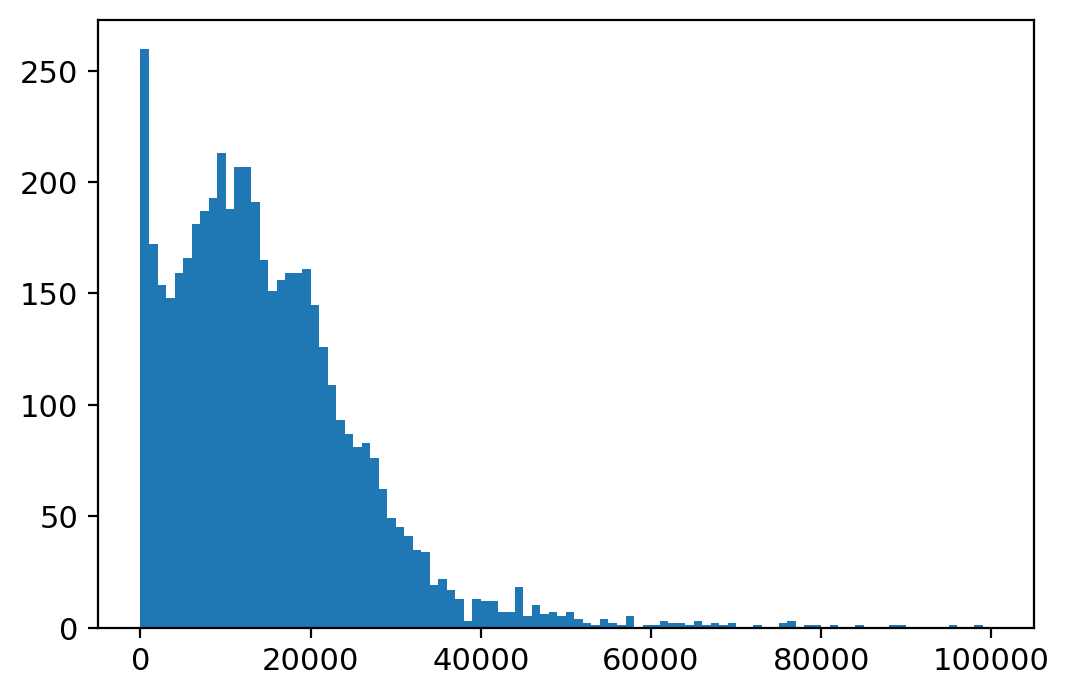

In [32]:
# Let's examine the total count distribution and remove outliers.
plt.hist(adata_atac.X.sum(1), bins=100, range=(0, 100000))

In [33]:
sc.pp.filter_cells(adata_atac, min_counts=2000)
sc.pp.filter_cells(adata_atac, max_counts=60000)

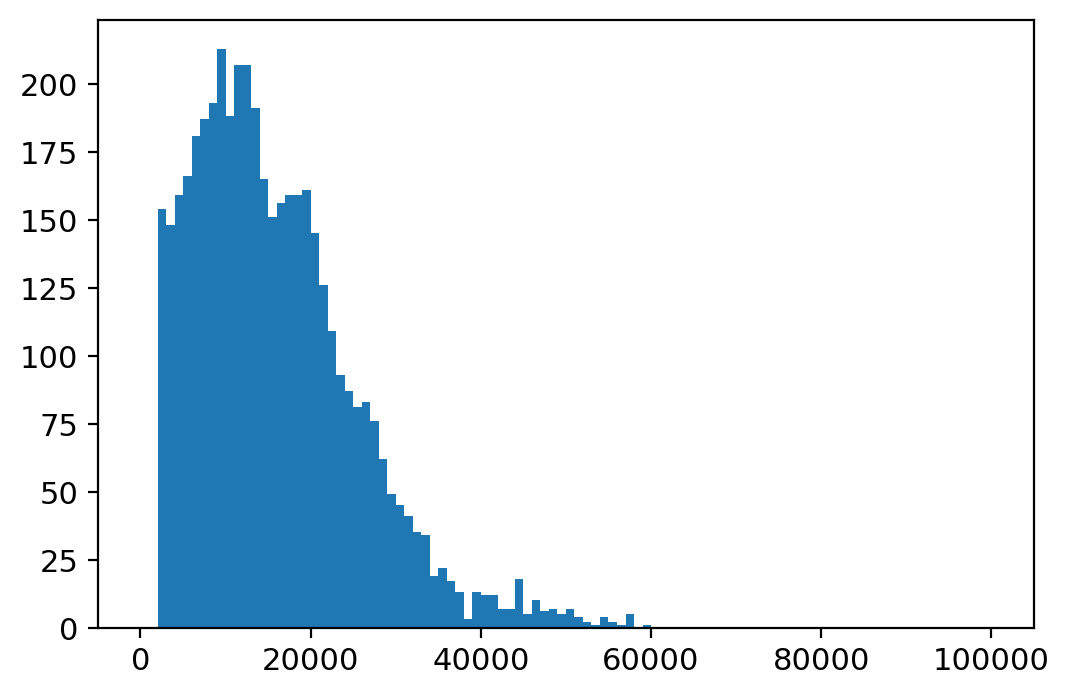

In [34]:
plt.hist(adata_atac.X.sum(1), bins=100, range=(0, 100000));

# 3. Finding shared barcodes and features between RNA and ATAC

In [35]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)

(3365, 936)

In [37]:
adata_rna = scv.read("/home/ouyangkang/data/multivelo/velocyto/10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [38]:
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

In [39]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [40]:
adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [41]:
# Reorder the categories for color consistency with the manuscript.
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)

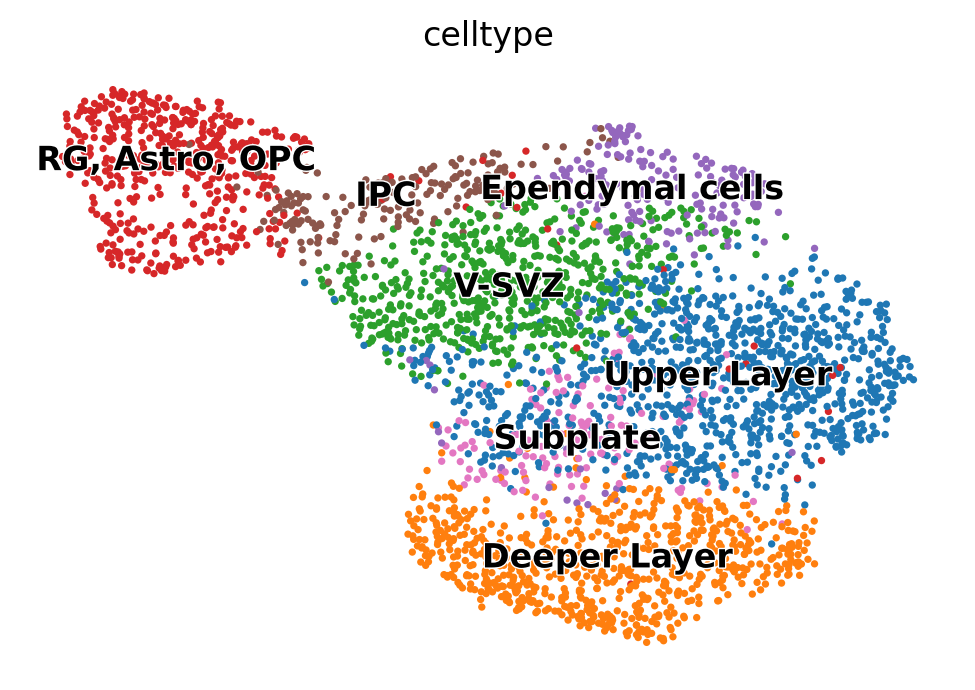

In [42]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype')

# 4. Smoothing gene aggregagted peaks by neighbors

In [43]:
# Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
adata_rna.obs_names.to_frame().to_csv('/home/ouyangkang/data/multivelo/filtered_cells.txt', header=False, index=False)

In [44]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("/home/ouyangkang/data/multivelo/seurat_wnn/nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("/home/ouyangkang/data/multivelo/seurat_wnn/nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("/home/ouyangkang/data/multivelo/seurat_wnn/nn_cells.txt", header=None)[0])

# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)

True

In [45]:
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

In [46]:
adata_atac

AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'n_counts'
    layers: 'Mc'
    obsp: 'connectivities'

# 5. Running multi-omic dynamical model
MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

In [47]:
help(mv.recover_dynamics_chrom)

Help on function recover_dynamics_chrom in module multivelo.dynamical_chrom_func:

recover_dynamics_chrom(adata_rna, adata_atac=None, gene_list=None, max_iter=5, init_mode='invert', model_to_run=None, verbose=False, plot=False, parallel=True, n_jobs=None, save_plot=False, plot_dir=None, rna_only=False, fit=True, fit_decoupling=True, extra_color_key=None, embedding='X_umap', n_anchors=500, k_dist=1, thresh_multiplier=1.0, weight_c=0.6, outlier=99.8, n_pcs=30, n_neighbors=30, fig_size=(8, 6), point_size=7, partial=None, direction=None, rescale_u=None, alpha=None, beta=None, gamma=None, t_sw=None)
    Multi-omic dynamics recovery.
    
    This function optimizes the joint chromatin and RNA model parameters in ODE solutions.
    
    Parameters
    ----------
    adata_rna: :class:`~anndata.AnnData`
        RNA anndata object. Required fields: `Mu`, `Ms`, and `connectivities`.
    adata_atac: :class:`~anndata.AnnData` (default: `None`)
        ATAC anndata object. Required fields: `Mc`.
 

In [48]:
# This will take a while. Parallelization is high recommended.
adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                         adata_atac, 
                                         max_iter=5, 
                                         init_mode="invert", 
                                         verbose=False, 
                                         parallel=True, 
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500, 
                                         extra_color_key='celltype'
                                        )

  0%|          | 0/936 [00:00<?, ?it/s]

In [49]:
adata_result.write('/home/ouyangkang/data/multivelo/multivelo_result.h5ad')

In [3]:
# breakpoint
adata_result = sc.read_h5ad("/home/ouyangkang/data/multivelo/multivelo_result.h5ad")

In [4]:
adata_result

AnnData object with n_obs × n_vars = 3365 × 865
    obs: 'n_counts', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes'
    uns: 'celltype_colors', 'neighbors', 'pca', 'umap', 'velo_chrom_params', 'velo_s_params', 'velo_u_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'fit_anchor_c', 'fit_anchor_c_sw', 'fit_anchor_c_velo', 'fit_anchor_s', 'fit_anchor_s_sw', 'fit_anchor_s_velo', 'fit_anchor_u', 'fit_anchor_u_sw', 'fit_anchor_u_velo'
    layers: 'ATAC', 'Ms', 'Mu', 'ambiguous', 'fit_state', 'fit_t', 'matrix', 'splice

In [10]:
adata_result

PairwiseArrays with keys: _ATAC_conn, _RNA_conn, connectivities, distances

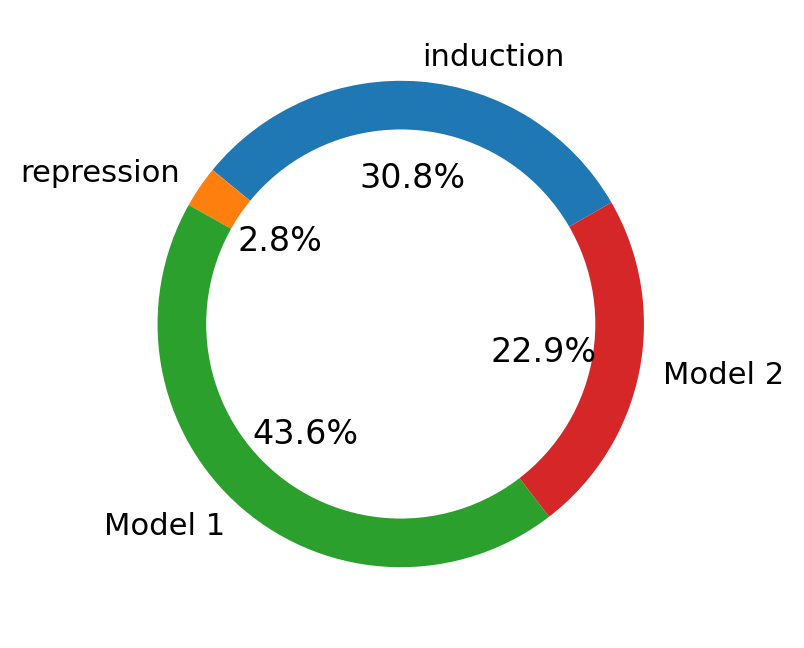

In [50]:
mv.pie_summary(adata_result)

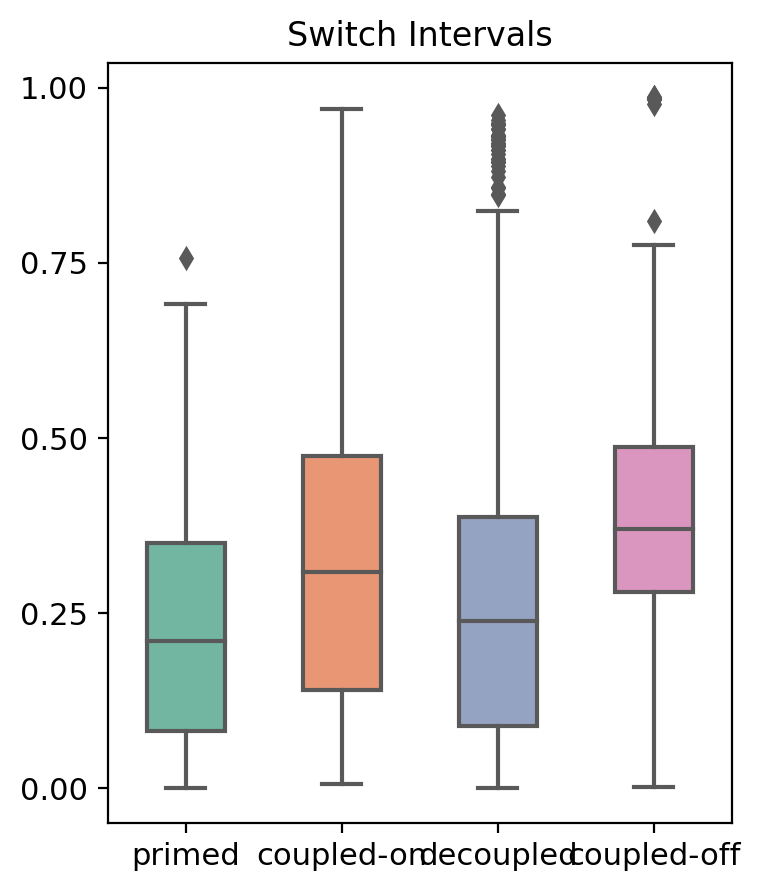

In [51]:
mv.switch_time_summary(adata_result)

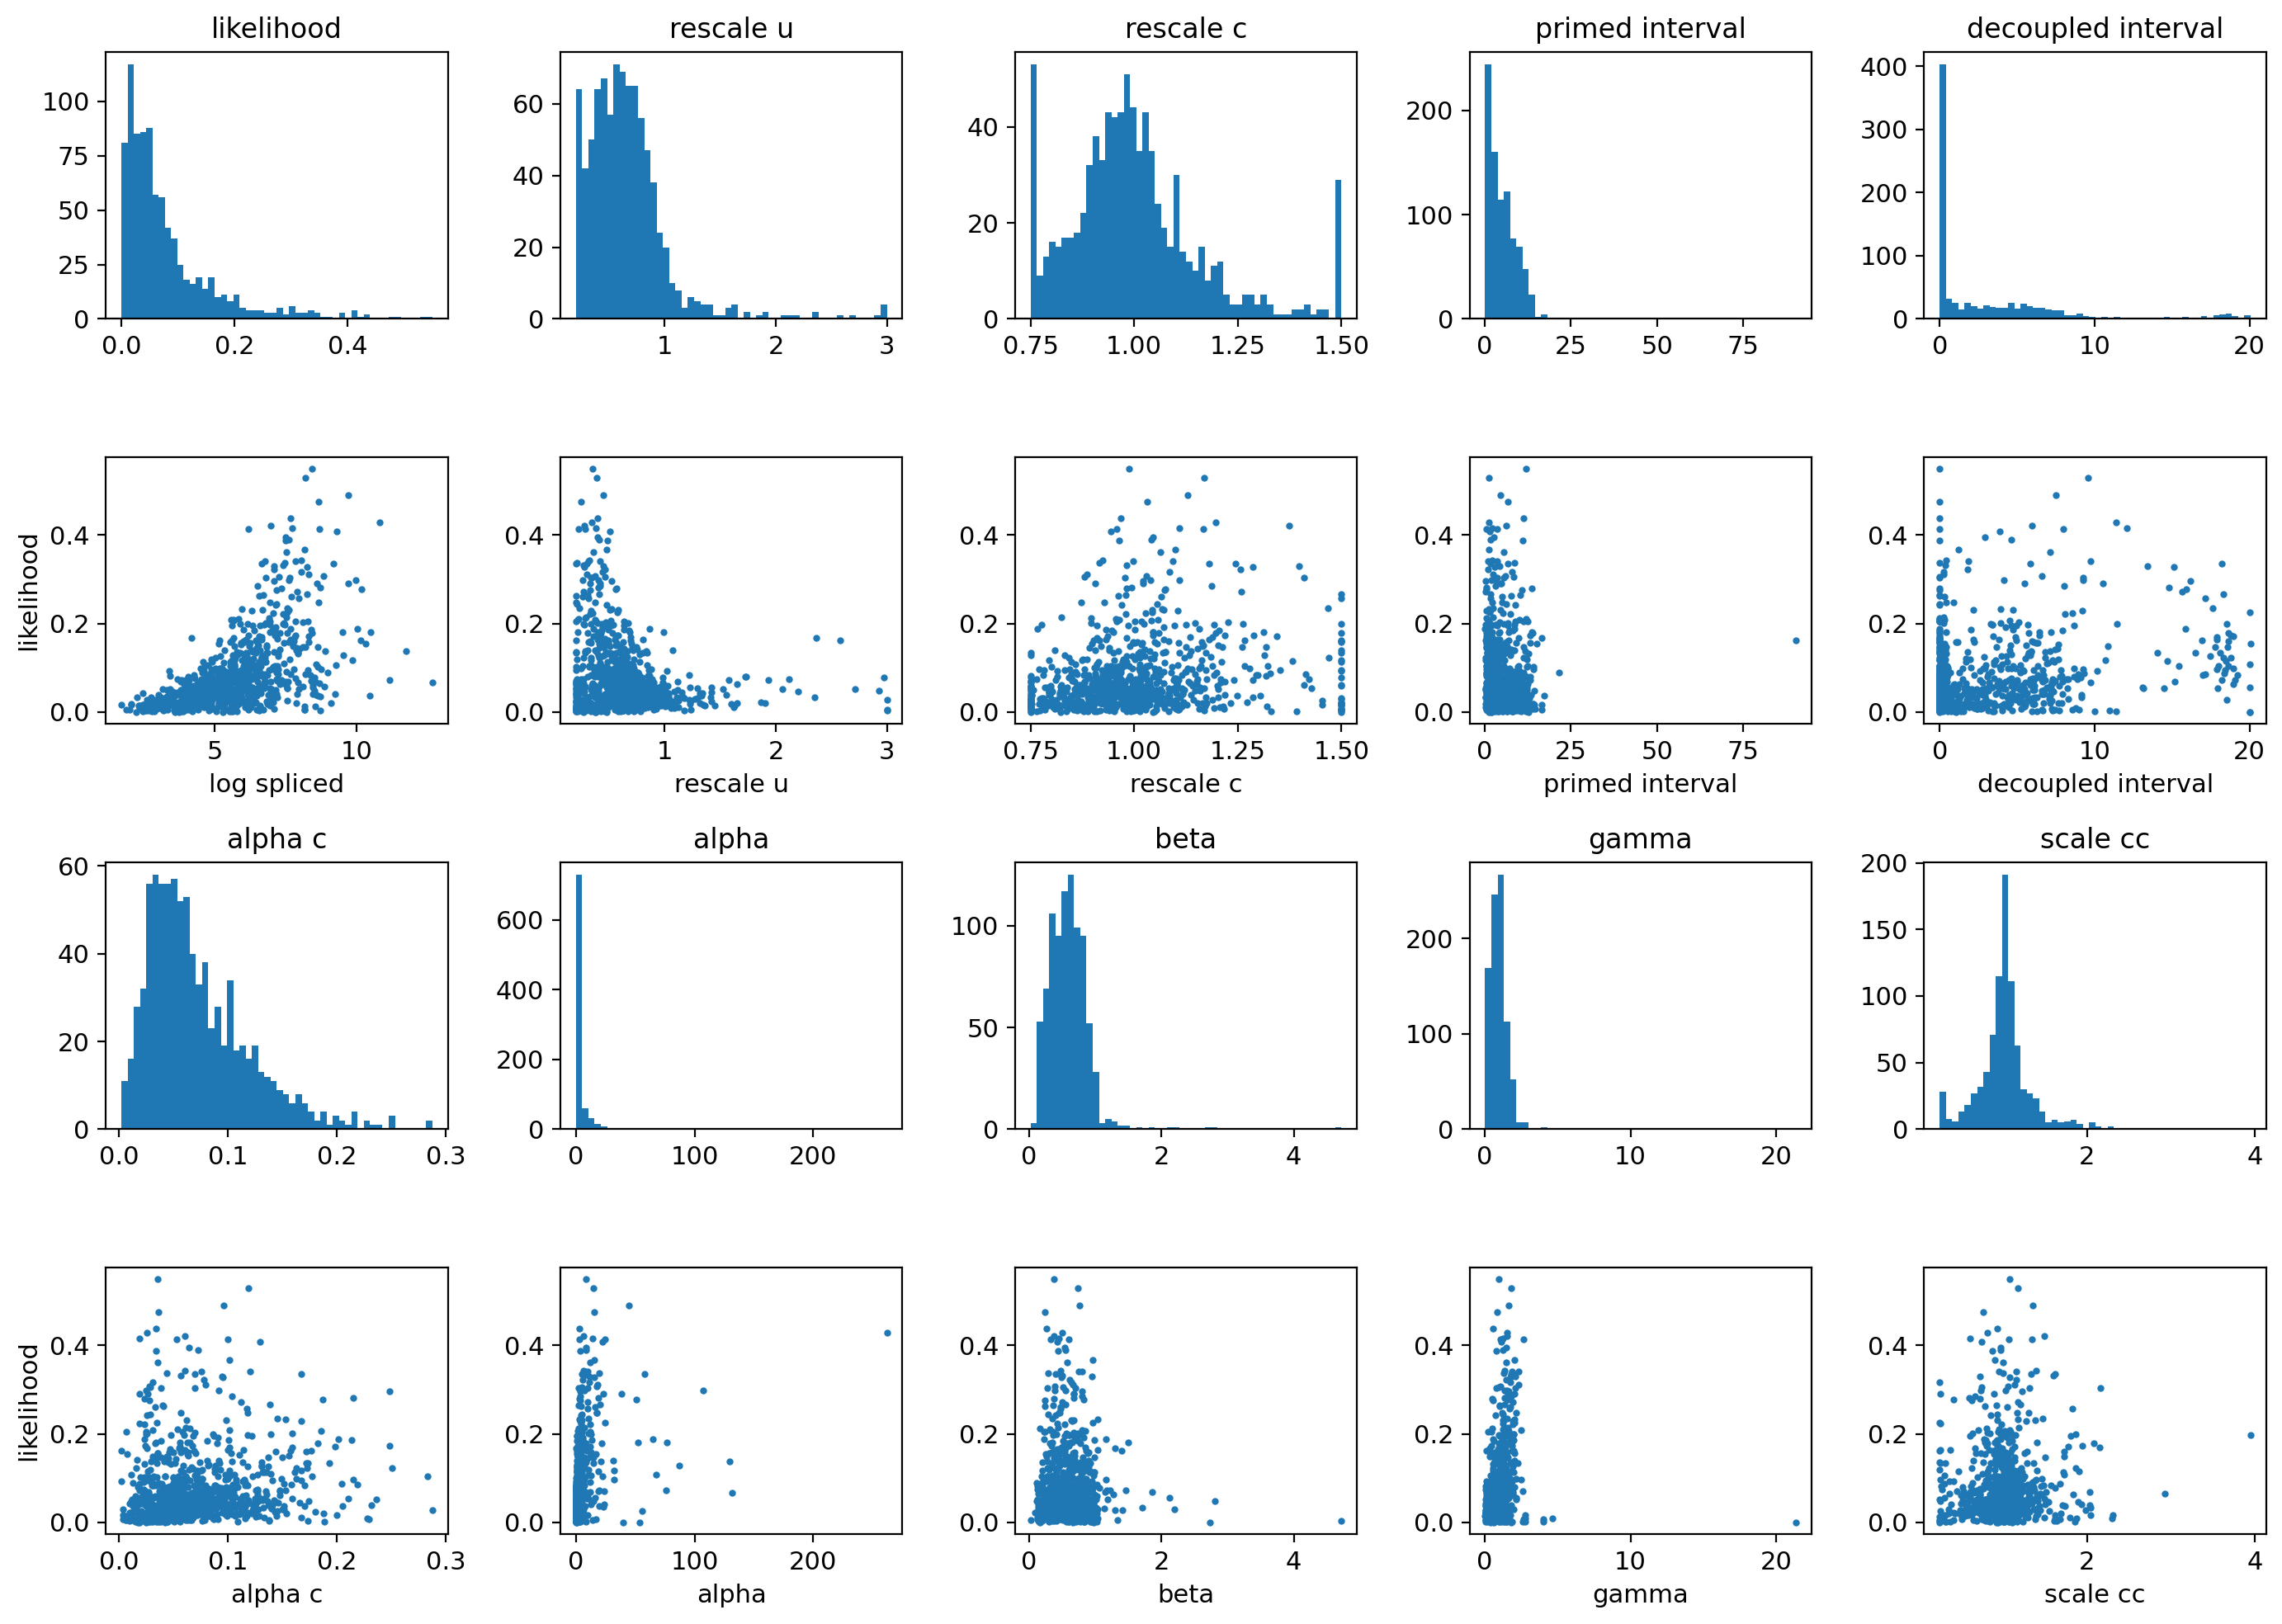

In [52]:
mv.likelihood_plot(adata_result)

By default, the velocity genes used for velocity graph is determined as those whose likelihoods are above 0.05. They can be reset with "mv.set_velocity_genes" function upon examining the distributions of variables above if needed.

# 6. Computing velocity stream and latent time

In [53]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:14) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


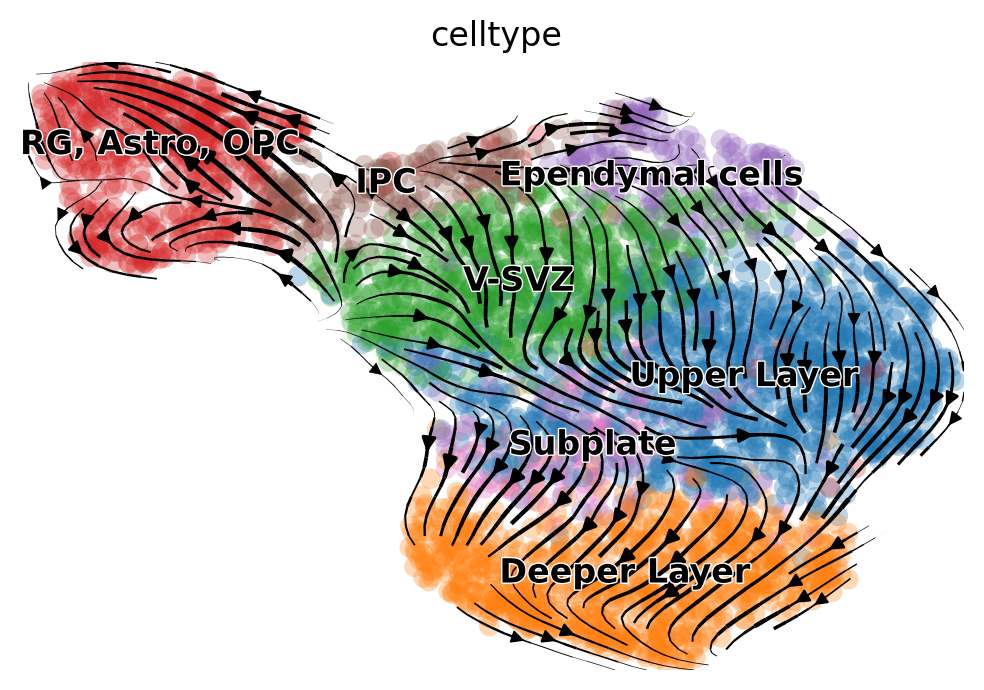

In [54]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype')

/home/ouyangkang/software/anaconda3/envs/scRNA/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


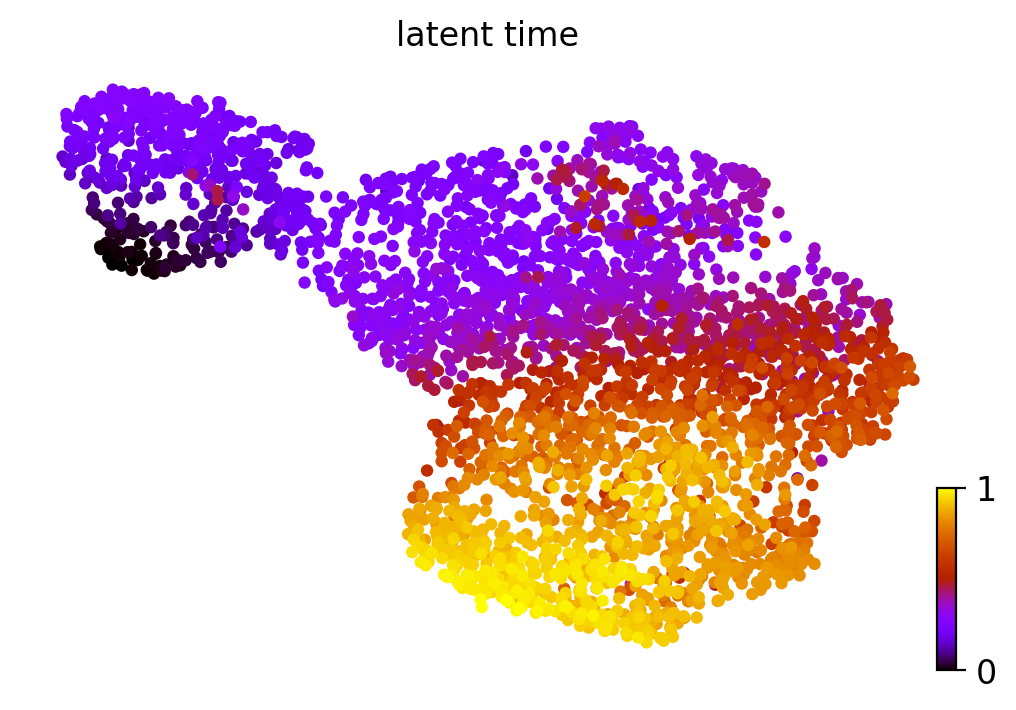

In [55]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

In [56]:
adata_result

AnnData object with n_obs × n_vars = 3365 × 865
    obs: 'n_counts', 'celltype', 'velo_s_norm_self_transition', 'root_cells', 'end_points', 'velo_s_norm_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes', 'velo_s_norm_genes'
    uns: 'pca', 'neighbors', 'umap', 'celltype_colors', 'velo_s_params', 'velo_u_params', 'velo_chrom_params', 'velo_s_norm_params', 'velo_s_norm_graph', 'velo_s_norm_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velo_s_norm_umap'
    varm: 'PCs', 'fit_anchor_c', 'fit_anchor_u', 'fit_ancho

In [59]:
adata_result.obs

,n_counts,celltype,velo_s_norm_self_transition,root_cells,end_points,velo_s_norm_pseudotime,latent_time
AAACAGCCAACCGCCA-1,681.0,Upper Layer,0.073836,0.061239,0.120563,0.820119,0.433805
AAACAGCCAAGGTCGA-1,296.0,"RG, Astro, OPC",0.109651,0.058221,0.473386,0.163211,0.232655
AAACAGCCAGGAACAT-1,504.0,Deeper Layer,0.050449,0.034611,0.324239,0.946184,0.902861
AAACAGCCATATTGAC-1,321.0,Deeper Layer,0.106093,0.004215,0.764667,0.995840,0.973763
AAACAGCCATGGTTAT-1,432.0,Subplate,0.075586,0.071876,0.114919,0.809997,0.482453
...,...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1,1248.0,Ependymal cells,0.117681,0.629832,0.007057,0.832731,0.373486
TTTGTGGCATTTGCTC-1,451.0,Upper Layer,0.081995,0.019995,0.517074,0.815727,0.583737
TTTGTGTTCAATGACC-1,369.0,IPC,0.146009,0.357688,0.041840,0.505644,0.250438
TTTGTTGGTGGAGCAA-1,513.0,Deeper Layer,0.022621,0.093438,0.125370,0.930687,0.811335


In [61]:
pseudotime = adata_result.obs['velo_s_norm_pseudotime']

In [63]:
gene_exp_mat = adata_result.X

In [72]:
pseu_gene_mat = gene_exp_mat * np.tile(pseudotime.values, (gene_exp_mat.shape[1], 1)).T

ValueError: dimension mismatch

In [73]:
gene_exp_mat.shape

(3365, 865)

In [74]:
np.tile(pseudotime.values, (gene_exp_mat.shape[1], 1)).T.shape

(3365, 865)